知识就是常写常新，常看常新。又到了定期手撕 Transformer 的季节。

计算注意力的流程可以分解为以下两个步骤：
- 计算 Q 和 K 的相似度；
- 根据计算得到的相似度，取出 V 每条信息中和 Q 有关的内容；

注意力机制本身并没有对 Q，K 和 V 的内容做出任何限制。比如，我们现在希望计算音频和文本之间的注意力，或者说希望从音频特征中提取和文本相关的信息，那么这个时候应该将文本特征作为 Q，音频特征作为 K 和 V（交叉注意力机制）；又比如，我们希望计算文本和文本自身的注意力，那么就应该将文本特征同时作为 
Q，K 和 V（自注意力机制）。

如下，可以假设图像切后有 100 个 tokens，而文本有 256 个 tokens。现在就能通过注意力算子计算出**用图像语义信息当作查询、从“文本数据库”中软检索出的相关知识**。头数按照 GPT-2 的设置来。

In [13]:
q_len, k_len, v_len = 100, 256, 256

batch_size = 32
hidden_dim = 768
head_dim = 64

如下是切分头和合并头的操作。之所以切分头是要最后两个维度是 len 和 hidden dim per head，方便进行矩阵运算（前面的维度会自动 broadcast）。

In [19]:
import torch
def split_head(x: torch.tensor, num_heads=12):
    b, l, h = x.size()
    x = x.reshape(b, l, num_heads, h // num_heads).transpose(1, 2)
    return x

x = torch.randn(batch_size, q_len, hidden_dim)
x = split_head(x, num_heads=12)
x.shape

torch.Size([32, 12, 100, 64])

In [25]:
def merge_head(x: torch.tensor):
    b, num_heads, l, h_per_heads = x.size()
    x = x.transpose(1, 2).reshape(b, l, num_heads * h_per_heads)
    return x

merge_head(x).shape

torch.Size([32, 100, 768])

以下是几种等效写法，比如 transpose 可以换成 permute；reshape 可以用 view 替代；用 ein 表达式更快。

In [24]:
x = torch.randn(32, 12, 100, 64)

x1 = x.transpose(1, 2).reshape(32, 100, 64 * 12)
x2 = x.permute(0, 2, 1, 3).reshape(32, 100, 64 * 12)
x3 = x.transpose(1, 2).contiguous().view(32, 100, 64 * 12)

from einops import rearrange
x4 = rearrange(x, 'b h l d -> b l (h d)')

torch.allclose(x1, x2), torch.allclose(x1, x3), torch.allclose(x1, x4)

(True, True, True)

如下，Q、K 和 V 在分头后最后两维会进行运算，第二维是不同的 heads。

In [28]:
q, k, v = torch.randn(32, 100, 768), torch.randn(32, 256, 768), torch.randn(32, 256, 768)
q, k, v = map(split_head, (q, k, v))
q.shape, k.shape, v.shape

(torch.Size([32, 12, 100, 64]),
 torch.Size([32, 12, 256, 64]),
 torch.Size([32, 12, 256, 64]))

有关 padding，是在每层的、每个头的 attention-mask 上都套上一个 padding mask，以确保这些部分激活值为 0。这意味着 value 不会从这些位置分配到权重，在反传时，这些位置也不会有梯度的。

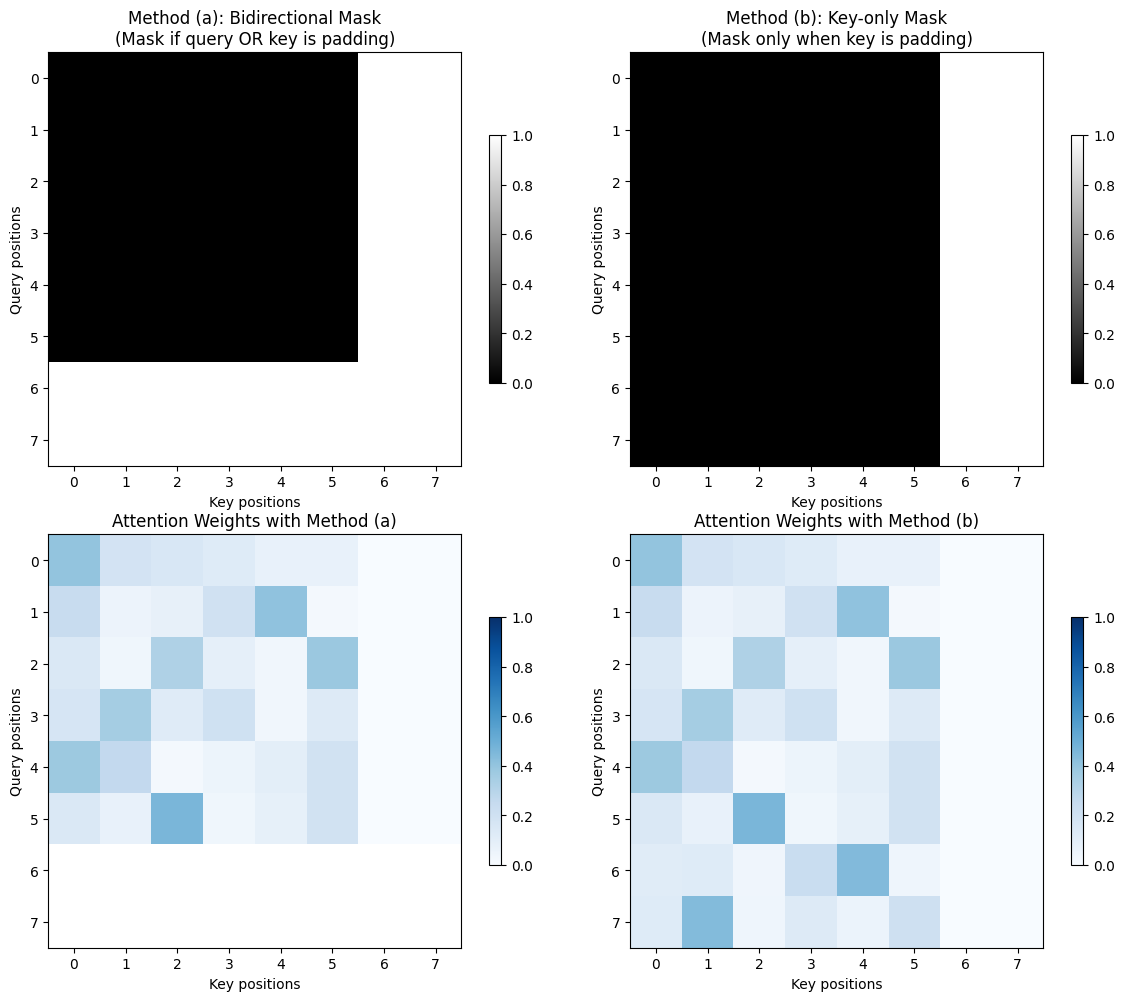

Analysis of potential NaN issues:
Method (a) - NaN in attention weights: True
Method (b) - NaN in attention weights: False

Attention weights for padded query position 6 (batch 0):
Method (a): tensor([nan, nan, nan, nan, nan, nan, nan, nan])
Method (b): tensor([0.1144, 0.1239, 0.0429, 0.2312, 0.4418, 0.0458, 0.0000, 0.0000])

Loss calculation demonstration:
Target tokens (batch 0): tensor([970, 822, 890, 205, 516, 265, 999, 999])
Padding positions marked with token 999
Loss with ignore_index: 7.5997
Loss without ignore_index: 7.5806


In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# First, let's create some demo data with padding
batch_size, seq_len, d_model = 2, 8, 512
# Create sequences with different lengths (simulating padding)
# Sequence 1: actual length 6, padded to 8
# Sequence 2: actual length 4, padded to 8
actual_lengths = [6, 4]

# Create attention scores (before softmax)
attention_scores = torch.randn(batch_size, seq_len, seq_len)

# Method (a): Bidirectional padding mask - mask if either query OR key is padding
def create_bidirectional_padding_mask(actual_lengths, seq_len, batch_size):
    mask = torch.ones(batch_size, seq_len, seq_len, dtype=torch.bool)
    for b, length in enumerate(actual_lengths):
        # Keep only the valid positions (both query and key are valid)
        mask[b, :length, :length] = False
    return mask

# Method (b): Key-only padding mask - mask only when key is padding
def create_key_padding_mask(actual_lengths, seq_len, batch_size):
    mask = torch.ones(batch_size, seq_len, seq_len, dtype=torch.bool)
    for b, length in enumerate(actual_lengths):
        # For each query position, mask only the padded key positions
        mask[b, :, :length] = False
    return mask

# Create both types of masks
bidirectional_mask = create_bidirectional_padding_mask(actual_lengths, seq_len, batch_size)
key_only_mask = create_key_padding_mask(actual_lengths, seq_len, batch_size)

# Visualize the masks
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Visualize masks for batch 0 (sequence length 6)
im1 = axes[0, 0].imshow(bidirectional_mask[0].numpy(), cmap='gray', vmin=0, vmax=1)
axes[0, 0].set_title('Method (a): Bidirectional Mask\n(Mask if query OR key is padding)')
axes[0, 0].set_xlabel('Key positions')
axes[0, 0].set_ylabel('Query positions')

im2 = axes[0, 1].imshow(key_only_mask[0].numpy(), cmap='gray', vmin=0, vmax=1)
axes[0, 1].set_title('Method (b): Key-only Mask\n(Mask only when key is padding)')
axes[0, 1].set_xlabel('Key positions')
axes[0, 1].set_ylabel('Query positions')

# Apply masks and compute attention weights
def apply_mask_and_softmax(scores, mask):
    masked_scores = scores.masked_fill(mask, float('-inf'))
    attention_weights = torch.softmax(masked_scores, dim=-1)
    return attention_weights

attention_weights_a = apply_mask_and_softmax(attention_scores, bidirectional_mask)
attention_weights_b = apply_mask_and_softmax(attention_scores, key_only_mask)

# Visualize attention weights
im3 = axes[1, 0].imshow(attention_weights_a[0].detach().numpy(), cmap='Blues', vmin=0, vmax=1)
axes[1, 0].set_title('Attention Weights with Method (a)')
axes[1, 0].set_xlabel('Key positions')
axes[1, 0].set_ylabel('Query positions')

im4 = axes[1, 1].imshow(attention_weights_b[0].detach().numpy(), cmap='Blues', vmin=0, vmax=1)
axes[1, 1].set_title('Attention Weights with Method (b)')
axes[1, 1].set_xlabel('Key positions')
axes[1, 1].set_ylabel('Query positions')

# Add colorbars
plt.colorbar(im1, ax=axes[0, 0], shrink=0.6)
plt.colorbar(im2, ax=axes[0, 1], shrink=0.6)
plt.colorbar(im3, ax=axes[1, 0], shrink=0.6)
plt.colorbar(im4, ax=axes[1, 1], shrink=0.6)

plt.tight_layout()
plt.show()

# Check for NaN values
print("Analysis of potential NaN issues:")
print(f"Method (a) - NaN in attention weights: {torch.isnan(attention_weights_a).any()}")
print(f"Method (b) - NaN in attention weights: {torch.isnan(attention_weights_b).any()}")

# Show specific problematic rows (padded query positions)
print(f"\nAttention weights for padded query position 6 (batch 0):")
print(f"Method (a): {attention_weights_a[0, 6]}")
print(f"Method (b): {attention_weights_b[0, 6]}")

# Demonstrate the loss calculation with ignore_index
print("\n" + "="*50)
print("Loss calculation demonstration:")

# Create dummy logits and targets
vocab_size = 1000
ignore_token_id = 999  # Special token for padding

# Simulate logits for a sequence
logits = torch.randn(batch_size, seq_len, vocab_size)
targets = torch.randint(0, vocab_size-1, (batch_size, seq_len))

# Set padding positions to ignore_token_id
for b, length in enumerate(actual_lengths):
    targets[b, length:] = ignore_token_id

print(f"Target tokens (batch 0): {targets[0]}")
print(f"Padding positions marked with token {ignore_token_id}")

# Calculate loss with and without ignore_index
loss_with_ignore = torch.nn.functional.cross_entropy(
    logits.view(-1, vocab_size), targets.view(-1), ignore_index=ignore_token_id
)
loss_without_ignore = torch.nn.functional.cross_entropy(
    logits.view(-1, vocab_size), targets.view(-1)
)

print(f"Loss with ignore_index: {loss_with_ignore:.4f}")
print(f"Loss without ignore_index: {loss_without_ignore:.4f}")